In [1]:
import torchvision
import torch
import torch.utils.data as utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import tqdm
from torch.autograd import Variable
import argparse
import os
import gc
import matplotlib.pyplot as plt
from copy import deepcopy
from PIL import Image
data_path = '../datasets/'


# from backpack import backpack, extend
# from backpack.extensions import (
#     GGNMP,
#     HMP,
#     KFAC,
#     KFLR,
#     KFRA,
#     PCHMP,
#     BatchGrad,
#     BatchL2Grad,
#     DiagGGNExact,
#     DiagGGNMC,
#     DiagHessian,
#     SumGradSquared,
#     Variance,
# )

In [2]:
class MNISTCDataset(Dataset):
    
    """MNIST-C dataset."""

    def __init__(self, root, train, transform=None, target_transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        if train:
            self.data = torch.tensor(np.load(root + '/train_images.npy'))
            self.targets = torch.tensor(np.load(root + '/train_labels.npy'))
        else:
            self.data = torch.tensor(np.load(root + '/test_images.npy'))
            self.targets = torch.tensor(np.load(root + '/test_labels.npy'))
            
        self.train=train
        self.root = root
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.targets)
    

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index][:,:,0], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target


In [3]:
trans = ([transforms.ToTensor()])
trans = transforms.Compose(trans)

fulltrainset = torchvision.datasets.MNIST(root=data_path, train=True, download=True, transform=trans)
train_set, valset = torch.utils.data.random_split(fulltrainset, [55000, 5000])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
validloader = torch.utils.data.DataLoader(valset, batch_size=128, shuffle=False,
                                          num_workers=4, pin_memory=True)

test_set = torchvision.datasets.MNIST(root=data_path, train=False, download=True, transform=trans)
testloader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)
nb_classes = 10

rand_labels_raw = torch.randint(0, 10, fulltrainset.targets.shape)
rand_labels_train, rand_labels_val = torch.utils.data.random_split(rand_labels_raw, [55000, 5000])

rand_labels_train = torch.utils.data.DataLoader(rand_labels_train, batch_size=128, shuffle=True, num_workers=4)
rand_labels_val = torch.utils.data.DataLoader(rand_labels_val, batch_size=128, shuffle=True, num_workers=4)


mnist_c_bright_trainset = MNISTCDataset(root='../datasets/mnist_c/translate', train=False, transform=trans)
mnist_c_bright_trainloader = torch.utils.data.DataLoader(mnist_c_bright_trainset, batch_size=128, shuffle=True, num_workers=4)

In [4]:
trainloader.dataset.dataset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [12]:
torch.randint(0, 10, (10,),replace=False)

TypeError: randint() received an invalid combination of arguments - got (int, int, tuple, replace=bool), but expected one of:
 * (int high, tuple of ints size, *, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool requires_grad)
 * (int low, int high, tuple of ints size, *, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool requires_grad)


In [20]:
new_mapping = dict(zip(range(10), np.random.choice(10, 10, replace=False)))

In [23]:
test_list=[new_mapping[x] for x in trainloader.dataset.dataset.targets[0:10].numpy()]

In [25]:
torch.tensor(test_list)

tensor([0, 2, 1, 7, 3, 8, 7, 6, 7, 1])

In [32]:
def test(loader, model, save=False, epoch=0, bn_eval=True):
    
    if bn_eval: # forward prop data twice to update BN running averages
        model.train()
        for _ in range(2):
            for batch_idx, (inputs, targets) in enumerate(loader):
                if use_cuda:
                    inputs, targets = inputs.cuda(), targets.cuda()
                _ = (model(inputs))

    model.eval()
    correct, total, total_loss = 0,0,0
    tot_iters = len(loader)
#     for batch_idx in tqdm.tqdm(range(tot_iters), total=tot_iters):
#         inputs, targets = next(iter(loader)) 
    for batch_idx, (inputs, targets) in enumerate(loader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            outputs = (model(inputs, True))

            _, predicted = torch.max(nn.Softmax(dim=1)(outputs).data, 1)
            total += targets.size(0)
            correct += torch.sum(predicted.eq(targets.data)).cpu()
            total_loss += model.loss_fn(outputs, targets)

    # Save checkpoint.
    acc = 100.*float(correct)/float(total)
    loss = total_loss/tot_iters
#     if save and acc > best_acc:
#         best_acc = acc
#         print('Saving best model..')
#         state = {
#             'model': model0,
#             'epoch': epoch
#         }
#         with open(args.save_dir + '/best_model.pt', 'wb') as f:
#             torch.save(state, f)
    return loss, acc

In [33]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.fc1 = nn.Linear(784, 300)
        self.fc2 = nn.Linear(300, 100)
        self.final_feat_dim=100
#         self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
#         x = self.fc3(x)
        return x

In [42]:
class RandomGame(nn.Module):
    def __init__(self, model_func, num_class, multi_rand_layer=[], loss_type = 'softmax'):
        super(RandomGame, self).__init__()
        self.feature    = model_func()
        
        self.true_classifier = nn.Linear(self.feature.final_feat_dim, num_class, bias=True)

        self.multi_rand_layer = multi_rand_layer
        rand_trunk = []
        if len(multi_rand_layer) == 0:
            rand_trunk.append(nn.Linear(self.feature.final_feat_dim, num_class, bias=True))
        else:
            prev_layer_dim=self.feature.final_feat_dim
            for i in self.multi_rand_layer:
                rand_trunk.append(nn.Linear(prev_layer_dim, i, bias = True))
                rand_trunk.append(nn.ReLU(inplace=True))
                prev_layer_dim = i
            rand_trunk.append(nn.Linear(prev_layer_dim, num_class, bias = True))
            
        self.rand_classifier = nn.Sequential(*rand_trunk)
        
        self.num_class = num_class
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x, true_flag):
        embedding  = self.feature.forward(x)
        
        if true_flag:
            out = self.true_classifier.forward(embedding)
        else:
            out = self.rand_classifier.forward(embedding)
        return out
    
    def train_rand(self):
        for name, param in self.named_parameters():
            if 'rand' not in name:
                param.requires_grad = False
            else:
                param.requires_grad = True
                
    def train_true(self):
        for name, param in self.named_parameters():
            if 'rand' not in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
                
#     def forward_true(self, x):
#         x    = Variable(x.cuda())
#         embedding  = self.feature.forward(x)
#         out = self.true_classifier.forward(embedding)
#         return embedding
    
#     def forward_rand(self, x):
#         x    = Variable(x.cuda())
#         embedding  = self.feature.forward(x)
#         out = self.rand_classifier.forward(embedding)
#         return embedding

In [38]:
trunk=[]
prev_layer_dim=100
for i in [64, 32]:
    trunk.append(nn.Linear(prev_layer_dim, i, bias = True))
    trunk.append(nn.ReLU(inplace=True))
    prev_layer_dim = i
trunk.append(nn.Linear(prev_layer_dim, 10, bias = True))

In [39]:
trunk

[Linear(in_features=100, out_features=64, bias=True),
 ReLU(inplace=True),
 Linear(in_features=64, out_features=32, bias=True),
 ReLU(inplace=True),
 Linear(in_features=32, out_features=10, bias=True)]

In [40]:
trunk = nn.Sequential(*trunk)

In [41]:
trunk

Sequential(
  (0): Linear(in_features=100, out_features=64, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=32, out_features=10, bias=True)
)

In [64]:
model = RandomGame(model_func=LeNet, num_class = 10, multi_rand_layer=[])

In [81]:
cur_weights

[tensor([[-4.6505e-04, -2.0728e-02, -3.2922e-02, -3.8461e-02, -6.1595e-02,
          -5.6390e-03,  5.0472e-02, -4.4825e-02, -9.6168e-02, -9.1528e-02,
           8.1942e-02,  3.8049e-02, -4.0895e-02,  6.4020e-02, -6.7884e-02,
           6.3478e-03,  1.6959e-02,  2.3627e-02, -7.6719e-02,  3.2788e-02,
           4.3599e-02,  6.5157e-02,  3.9421e-02, -6.3814e-02, -5.5647e-04,
          -5.1167e-02,  4.8136e-02, -7.5035e-02, -5.6002e-02,  8.8924e-02,
           6.7727e-02,  2.3894e-02,  3.8892e-02,  2.6329e-02, -9.0016e-02,
           2.7490e-02,  1.1930e-02, -2.6328e-02,  6.8502e-02, -6.6443e-02,
           7.2061e-02, -2.6601e-02, -6.9212e-02,  7.9581e-02, -5.9808e-02,
          -6.8134e-02, -9.2334e-02,  4.2729e-02,  9.3029e-02,  2.3482e-02,
          -1.6549e-02,  5.7481e-02,  1.6357e-02,  3.0266e-02,  2.0038e-03,
          -1.3573e-02,  5.8325e-02,  1.5835e-02, -2.5260e-02, -8.2736e-02,
          -1.6604e-02, -9.3048e-02, -6.9821e-02,  2.1179e-02,  8.2467e-02,
          -8.3811e-02,  5

In [76]:
cur_weights=[]
for name, param in model.named_parameters():
    if 'true' in name:
        cur_weights.append(param.data.clone())

In [ ]:
model.rand_classifier.

In [94]:
torch.nn.init.zeros_(param.data)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [92]:
param.data

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0675, -0.0447,  0.0399,
         0.0088,  0.0798])

In [95]:
for name, param in model.named_parameters():
    if 'rand' in name and 'weight' in name:
        break
#     print(name)

In [97]:
torch.nn.init.xavier_uniform_(param)

Parameter containing:
tensor([[ 2.1025e-01,  2.6464e-02,  1.2087e-01,  8.6465e-02, -2.1665e-01,
         -4.9262e-02, -1.9231e-01, -7.8100e-02, -4.0198e-02, -1.9107e-01,
          2.3115e-01, -2.0622e-01,  5.9121e-02,  1.5132e-02,  1.4697e-01,
          2.2291e-01,  1.8676e-01, -1.8293e-02, -7.2818e-02, -1.1411e-01,
          1.6557e-01,  1.4624e-01,  2.1000e-01,  1.2686e-01,  3.8684e-02,
          2.1641e-01, -8.6895e-03, -3.7500e-02, -1.3888e-01, -4.5061e-02,
         -5.8494e-02,  2.5730e-02,  6.6903e-02, -8.9521e-02, -2.2487e-01,
         -2.9454e-02,  6.6556e-02, -2.3424e-02,  1.4270e-01,  1.7334e-01,
          5.6950e-02,  1.7343e-01,  5.9820e-02, -1.2944e-01, -9.0060e-02,
         -1.8634e-01, -1.2320e-01, -4.6478e-02, -5.2073e-02, -8.8389e-02,
          1.3605e-01, -1.8000e-01, -6.8154e-03, -1.0941e-01,  1.6078e-01,
         -8.1040e-02, -1.0045e-01, -4.7802e-02,  9.8013e-02, -5.6373e-02,
         -9.9789e-02,  1.0171e-01,  2.3595e-02,  7.2821e-02,  9.3369e-02,
         -5.0843

In [103]:
for name, layer in model.named_children():
    if 'rand' in name:
        layer[0].reset_parameters()
#     print(name)

In [100]:
layer.n

<generator object Module.children at 0x7f0b32e499d0>

In [79]:
for name, param in model.named_parameters():
    if 'rand' in name:
        param.

In [84]:
param[0:5] = 0

In [86]:
cur_weights

[tensor([[-4.6505e-04, -2.0728e-02, -3.2922e-02, -3.8461e-02, -6.1595e-02,
          -5.6390e-03,  5.0472e-02, -4.4825e-02, -9.6168e-02, -9.1528e-02,
           8.1942e-02,  3.8049e-02, -4.0895e-02,  6.4020e-02, -6.7884e-02,
           6.3478e-03,  1.6959e-02,  2.3627e-02, -7.6719e-02,  3.2788e-02,
           4.3599e-02,  6.5157e-02,  3.9421e-02, -6.3814e-02, -5.5647e-04,
          -5.1167e-02,  4.8136e-02, -7.5035e-02, -5.6002e-02,  8.8924e-02,
           6.7727e-02,  2.3894e-02,  3.8892e-02,  2.6329e-02, -9.0016e-02,
           2.7490e-02,  1.1930e-02, -2.6328e-02,  6.8502e-02, -6.6443e-02,
           7.2061e-02, -2.6601e-02, -6.9212e-02,  7.9581e-02, -5.9808e-02,
          -6.8134e-02, -9.2334e-02,  4.2729e-02,  9.3029e-02,  2.3482e-02,
          -1.6549e-02,  5.7481e-02,  1.6357e-02,  3.0266e-02,  2.0038e-03,
          -1.3573e-02,  5.8325e-02,  1.5835e-02, -2.5260e-02, -8.2736e-02,
          -1.6604e-02, -9.3048e-02, -6.9821e-02,  2.1179e-02,  8.2467e-02,
          -8.3811e-02,  5

In [85]:
for name, param in model.named_parameters():
    if 'true' in name:
        print(param)

Parameter containing:
tensor([[-4.6505e-04, -2.0728e-02, -3.2922e-02, -3.8461e-02, -6.1595e-02,
         -5.6390e-03,  5.0472e-02, -4.4825e-02, -9.6168e-02, -9.1528e-02,
          8.1942e-02,  3.8049e-02, -4.0895e-02,  6.4020e-02, -6.7884e-02,
          6.3478e-03,  1.6959e-02,  2.3627e-02, -7.6719e-02,  3.2788e-02,
          4.3599e-02,  6.5157e-02,  3.9421e-02, -6.3814e-02, -5.5647e-04,
         -5.1167e-02,  4.8136e-02, -7.5035e-02, -5.6002e-02,  8.8924e-02,
          6.7727e-02,  2.3894e-02,  3.8892e-02,  2.6329e-02, -9.0016e-02,
          2.7490e-02,  1.1930e-02, -2.6328e-02,  6.8502e-02, -6.6443e-02,
          7.2061e-02, -2.6601e-02, -6.9212e-02,  7.9581e-02, -5.9808e-02,
         -6.8134e-02, -9.2334e-02,  4.2729e-02,  9.3029e-02,  2.3482e-02,
         -1.6549e-02,  5.7481e-02,  1.6357e-02,  3.0266e-02,  2.0038e-03,
         -1.3573e-02,  5.8325e-02,  1.5835e-02, -2.5260e-02, -8.2736e-02,
         -1.6604e-02, -9.3048e-02, -6.9821e-02,  2.1179e-02,  8.2467e-02,
         -8.3811

In [979]:
ce_loss_fn = nn.CrossEntropyLoss()
mse_loss_fn = nn.MSELoss(reduction='mean')

In [980]:
true_parameters = list(model.feature.parameters()) + list(model.true_classifier.parameters())

# Optimizers
optimizer_T = torch.optim.SGD(true_parameters, lr = 0.1, weight_decay=0.01)
optimizer_R = torch.optim.SGD(model.rand_classifier.parameters(), lr=0.1, weight_decay=0.01)

In [981]:
train_true = True
iter_counter = 0
changer_iter = 5

In [982]:
validloss_all = []
validacc_all = []
testloss_all = []
testacc_all = []
trainloss_all = []
trainacc_all = []

In [983]:
correct=0
total=0
correct_rand=0
validacc=0
testacc=0
validloss=0
testloss=0
print_every=50

In [984]:
use_cuda=True

In [985]:
model.cuda()

RandomGame(
  (feature): LeNet(
    (fc1): Linear(in_features=784, out_features=300, bias=True)
    (fc2): Linear(in_features=300, out_features=100, bias=True)
  )
  (true_classifier): Linear(in_features=100, out_features=10, bias=True)
  (rand_classifier): Linear(in_features=100, out_features=10, bias=True)
  (loss_fn): CrossEntropyLoss()
)

In [986]:
# torch.sum(model.true_classifier.weight)

# model.true_classifier.bias

# torch.sum(model.feature.fc1.weight)

In [987]:
gamma=0.25

In [988]:
model.train()

RandomGame(
  (feature): LeNet(
    (fc1): Linear(in_features=784, out_features=300, bias=True)
    (fc2): Linear(in_features=300, out_features=100, bias=True)
  )
  (true_classifier): Linear(in_features=100, out_features=10, bias=True)
  (rand_classifier): Linear(in_features=100, out_features=10, bias=True)
  (loss_fn): CrossEntropyLoss()
)

## ce version

In [3]:
2%1

0

In [989]:
train_true=True
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    running_loss_true = 0.0
    running_loss_rand = 0.0
    for i, (data, rand_labels) in enumerate(zip(trainloader, rand_labels_train), 0):
#     for i, data in enumerate(trainloader):

        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
#         rand_labels_oh = torch.nn.functional.one_hot(rand_labels).float()
#         rand_labels = torch.randint(0, 10, labels.shape)
        if use_cuda:
            inputs, labels, rand_labels = inputs.cuda(), labels.cuda(), rand_labels.cuda()


        # forward + backward + optimize

        if train_true:
            # zero the parameter gradients
            optimizer_T.zero_grad()        
            model.train_true()
            outputs_true = model(inputs, True)
            outputs_rand = model(inputs, False)

            true_loss=ce_loss_fn(outputs_true, labels)
            rand_loss=ce_loss_fn(outputs_rand, rand_labels)
            loss = 1.5*true_loss - gamma*rand_loss

            loss.backward()
            optimizer_T.step()
        
        
        if not train_true:
            model.train_rand()
#             for k in range(20):
            optimizer_R.zero_grad()
            outputs_rand = model(inputs, False)
            loss = ce_loss_fn(outputs_rand, rand_labels)
#             print(loss.cpu().detach().numpy())
            loss.backward()
            optimizer_R.step()
#                 print(loss.cpu().detach().numpy())
#                 train_true=True

        outputs_true = model(inputs, True)
        outputs_rand = model(inputs, False)
        
        _, predicted = torch.max(nn.Softmax(dim=1)(outputs_true).data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        
        _, predicted_rand = torch.max(nn.Softmax(dim=1)(outputs_rand).data, 1)
        correct_rand += predicted_rand.eq(rand_labels.data).cpu().sum()
        
#         if i == 0:
#             validloss, validacc = test(validloader, model, bn_eval=False)
#             testloss, testacc = test(testloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
#             testloss_all.append(testloss)
#             testacc_all.append(testacc)
#             trainloss_all.append(loss.item())
#             trainacc_all.append(correct.numpy() / total * 100)
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, loss.item(), correct.numpy() / total * 100, validloss, validacc, testloss, testacc))

        # print statistics
        running_loss += loss.item()
        running_loss_true += true_loss.item()
        running_loss_rand += rand_loss.item()
        if i % print_every == print_every-1:   
#             print(i)
#             weight_all, grad_all, variance_all, gsnr_all = save_gsnr_batch(model)
#             weight_all_time.append(weight_all)
#             grad_all_time.append(grad_all)
#             variance_all_time.append(variance_all)
#             gsnr_all_time.append(gsnr_all)
            
#             validloss, validacc = test(validloader, model, bn_eval=False)
            testloss, testacc = test(mnist_c_bright_trainloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
            testloss_all.append(testloss)
            testacc_all.append(testacc)
            trainloss_all.append(running_loss / print_every)
            trainacc_all.append(correct.numpy() / total * 100)
            print('[%d, %5d] rand loss: %.3f, true loss: %.3f, loss: %.3f, train acc: %.3f, rand_train_acc: %.3f, test acc: %.3f, train_true is %s, gamma is %.2f' %
                  (epoch + 1, i + 1, running_loss_rand / print_every, running_loss_true / print_every, running_loss / print_every, 
                   correct.numpy() / total * 100, correct_rand.numpy() / total * 100, testacc, train_true, gamma))
            
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, running_loss / print_every, correct.numpy() / total * 100, validloss, validacc, testloss, testacc))
            running_loss = 0.0
            running_loss_true = 0.0
            running_loss_rand = 0.0
            correct = 0
            correct_rand=0
            total = 0

        iter_counter += 1
        if iter_counter >= 1 and train_true:
            train_true = False
            iter_counter = 0
        
        if iter_counter >= 1 and not train_true:
            train_true = True
            iter_counter = 0
            
#         iter_counter += 1
#         if iter_counter >= 2 and train_true:
#             train_true=False
#             iter_counter = 0
            
#         if iter_counter >= 150 and not train_true:
#             train_true=True
#             iter_counter = 0
#             print('train_true is ' + str(train_true))

#         if i % 50 == 49:
#             gamma *= 1.1
        
#     if epoch > 2:
#         print('setting gamma to 0 at epoch %d' % epoch)
#         gamma = 0
    
print('Finished Training')

[1,    50] rand loss: 2.306, true loss: 2.223, loss: 2.531, train acc: 43.641, rand_train_acc: 9.781, test acc: 9.660, train_true is False, gamma is 0.25
[1,   100] rand loss: 2.319, true loss: 1.703, loss: 2.144, train acc: 65.188, rand_train_acc: 10.656, test acc: 9.850, train_true is False, gamma is 0.25
[1,   150] rand loss: 2.322, true loss: 0.943, loss: 1.577, train acc: 76.203, rand_train_acc: 12.000, test acc: 9.210, train_true is False, gamma is 0.25
[1,   200] rand loss: 2.333, true loss: 0.717, loss: 1.407, train acc: 80.344, rand_train_acc: 12.375, test acc: 9.910, train_true is False, gamma is 0.25
[1,   250] rand loss: 2.336, true loss: 0.536, loss: 1.283, train acc: 84.266, rand_train_acc: 12.281, test acc: 10.310, train_true is False, gamma is 0.25
[1,   300] rand loss: 2.330, true loss: 0.530, loss: 1.275, train acc: 84.922, rand_train_acc: 12.641, test acc: 10.970, train_true is False, gamma is 0.25
[1,   350] rand loss: 2.323, true loss: 0.481, loss: 1.242, train acc

In [953]:
gc.collect()

20

In [586]:
train_true=False
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    running_loss_true = 0.0
    running_loss_rand = 0.0
    for i, (data, rand_labels) in enumerate(zip(trainloader, rand_labels_train), 0):
#     for i, data in enumerate(trainloader):

        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
#         rand_labels_oh = torch.nn.functional.one_hot(rand_labels).float()
#         rand_labels = torch.randint(0, 10, labels.shape)
        if use_cuda:
            inputs, labels, rand_labels = inputs.cuda(), labels.cuda(), rand_labels.cuda()

        
        # zero the parameter gradients
        optimizer_T.zero_grad()        

        # forward + backward + optimize

        if not train_true:
            model.train_rand()
            for k in range(1):
                optimizer_R.zero_grad()
                outputs_rand = model(inputs, False)
                loss = ce_loss_fn(outputs_rand, rand_labels)
    #             print(loss.cpu().detach().numpy())
                loss.backward()
                optimizer_R.step()
#                 print(loss.cpu().detach().numpy())
                train_true=True
        
        model.train_true()
        outputs_true = model(inputs, True)
        outputs_rand = model(inputs, False)
        
        true_loss=ce_loss_fn(outputs_true, labels)
        rand_loss=ce_loss_fn(outputs_rand, rand_labels)
        loss = 1.5*true_loss - gamma*rand_loss
            
        loss.backward()
        optimizer_T.step()
        
        _, predicted = torch.max(nn.Softmax(dim=1)(outputs_true).data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        
        _, predicted_rand = torch.max(nn.Softmax(dim=1)(outputs_rand).data, 1)
        correct_rand += predicted_rand.eq(rand_labels.data).cpu().sum()
        
#         if i == 0:
#             validloss, validacc = test(validloader, model, bn_eval=False)
#             testloss, testacc = test(testloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
#             testloss_all.append(testloss)
#             testacc_all.append(testacc)
#             trainloss_all.append(loss.item())
#             trainacc_all.append(correct.numpy() / total * 100)
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, loss.item(), correct.numpy() / total * 100, validloss, validacc, testloss, testacc))

        # print statistics
        running_loss += loss.item()
        running_loss_true += true_loss.item()
        running_loss_rand += rand_loss.item()
        if i % print_every == print_every-1:   
#             print(i)
#             weight_all, grad_all, variance_all, gsnr_all = save_gsnr_batch(model)
#             weight_all_time.append(weight_all)
#             grad_all_time.append(grad_all)
#             variance_all_time.append(variance_all)
#             gsnr_all_time.append(gsnr_all)
            
#             validloss, validacc = test(validloader, model, bn_eval=False)
            testloss, testacc = test(mnist_c_bright_trainloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
            testloss_all.append(testloss)
            testacc_all.append(testacc)
            trainloss_all.append(running_loss / print_every)
            trainacc_all.append(correct.numpy() / total * 100)
            print('[%d, %5d] rand loss: %.3f, true loss: %.3f, loss: %.3f, train acc: %.3f, rand_train_acc: %.3f, test acc: %.3f, train_true is %s, gamma is %.2f' %
                  (epoch + 1, i + 1, running_loss_rand / print_every, running_loss_true / print_every, running_loss / print_every, 
                   correct.numpy() / total * 100, correct_rand.numpy() / total * 100, testacc, train_true, gamma))
            
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, running_loss / print_every, correct.numpy() / total * 100, validloss, validacc, testloss, testacc))
            running_loss = 0.0
            running_loss_true = 0.0
            running_loss_rand = 0.0
            correct = 0
            correct_rand=0
            total = 0

        iter_counter += 1
        if iter_counter >= 1 and train_true:
            train_true = False
            iter_counter = 0
            
#         iter_counter += 1
#         if iter_counter >= 2 and train_true:
#             train_true=False
#             iter_counter = 0
            
#         if iter_counter >= 150 and not train_true:
#             train_true=True
#             iter_counter = 0
#             print('train_true is ' + str(train_true))

        if i % 100 == 99:
            gamma *= 0.9
        
#     if epoch > 2:
#         print('setting gamma to 0 at epoch %d' % epoch)
#         gamma = 0
    
print('Finished Training')

[1,    50] rand loss: 2.298, true loss: 1.917, loss: 2.645, train acc: 51.828, rand_train_acc: 10.859, test acc: 19.920, train_true is True, gamma is 0.10
[1,   100] rand loss: 2.264, true loss: 0.746, loss: 0.893, train acc: 78.375, rand_train_acc: 15.391, test acc: 23.990, train_true is True, gamma is 0.10
[1,   150] rand loss: 2.247, true loss: 0.494, loss: 0.539, train acc: 85.188, rand_train_acc: 15.672, test acc: 42.090, train_true is True, gamma is 0.09
[1,   200] rand loss: 2.249, true loss: 0.413, loss: 0.417, train acc: 88.141, rand_train_acc: 15.984, test acc: 33.610, train_true is True, gamma is 0.09
[1,   250] rand loss: 2.246, true loss: 0.364, loss: 0.364, train acc: 89.531, rand_train_acc: 16.344, test acc: 42.690, train_true is True, gamma is 0.08
[1,   300] rand loss: 2.248, true loss: 0.338, loss: 0.325, train acc: 89.844, rand_train_acc: 15.859, test acc: 40.320, train_true is True, gamma is 0.08
[1,   350] rand loss: 2.248, true loss: 0.316, loss: 0.311, train acc:

KeyboardInterrupt: 

In [434]:
gc.collect()

38

## train without game

In [915]:
model.train_true()
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    running_loss_true = 0.0
    running_loss_rand = 0.0
    for i, (data, rand_labels) in enumerate(zip(trainloader, rand_labels_train), 0):

        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
#         rand_labels_oh = torch.nn.functional.one_hot(rand_labels).float()
            
        if use_cuda:
            inputs, labels, rand_labels = inputs.cuda(), labels.cuda(), rand_labels.cuda()

        
        # zero the parameter gradients
        optimizer_T.zero_grad()        

        # forward + backward + optimize

        outputs_true = model(inputs, True)
        
        loss=ce_loss_fn(outputs_true, labels)
            
        loss.backward()
        optimizer_T.step()
        
        _, predicted = torch.max(nn.Softmax(dim=1)(outputs_true).data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        
        
#         if i == 0:
#             validloss, validacc = test(validloader, model, bn_eval=False)
#             testloss, testacc = test(testloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
#             testloss_all.append(testloss)
#             testacc_all.append(testacc)
#             trainloss_all.append(loss.item())
#             trainacc_all.append(correct.numpy() / total * 100)
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, loss.item(), correct.numpy() / total * 100, validloss, validacc, testloss, testacc))

        # print statistics
        running_loss += loss.item()
        if i % print_every == print_every-1:   
#             print(i)
#             weight_all, grad_all, variance_all, gsnr_all = save_gsnr_batch(model)
#             weight_all_time.append(weight_all)
#             grad_all_time.append(grad_all)
#             variance_all_time.append(variance_all)
#             gsnr_all_time.append(gsnr_all)
            
#             validloss, validacc = test(validloader, model, bn_eval=False)
            testloss, testacc = test(mnist_c_bright_trainloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
            testloss_all.append(testloss)
            testacc_all.append(testacc)
            trainloss_all.append(running_loss / print_every)
            trainacc_all.append(correct.numpy() / total * 100)
            print('[%d, %5d] loss: %.3f, train acc: %.3f, test acc: %.3f, train_true is %s, gamma is %.2f' %
                  (epoch + 1, i + 1, running_loss / print_every, 
                   correct.numpy() / total * 100, testacc, train_true, gamma))
            
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, running_loss / print_every, correct.numpy() / total * 100, validloss, validacc, testloss, testacc))
            running_loss = 0.0
            running_loss_true = 0.0
            running_loss_rand = 0.0
            correct = 0
            correct_rand=0
            total = 0

#         iter_counter += 1
#         if iter_counter >= 1 and train_true:
#             train_true = False
#             iter_counter = 0
            
#         iter_counter += 1
#         if iter_counter >= 2 and train_true:
#             train_true=False
#             iter_counter = 0
            
#         if iter_counter >= 150 and not train_true:
#             train_true=True
#             iter_counter = 0
#             print('train_true is ' + str(train_true))

#         if i % 100 == 99:
#             gamma *= 1.1
    
print('Finished Training')

[1,    50] loss: 2.187, train acc: 43.438, test acc: 12.080, train_true is True, gamma is 0.10
[1,   100] loss: 1.297, train acc: 72.594, test acc: 10.610, train_true is True, gamma is 0.10
[1,   150] loss: 0.639, train acc: 82.391, test acc: 9.250, train_true is True, gamma is 0.10
[1,   200] loss: 0.474, train acc: 86.656, test acc: 10.200, train_true is True, gamma is 0.10
[1,   250] loss: 0.424, train acc: 87.922, test acc: 10.110, train_true is True, gamma is 0.10
[1,   300] loss: 0.391, train acc: 88.578, test acc: 11.690, train_true is True, gamma is 0.10
[1,   350] loss: 0.381, train acc: 89.078, test acc: 11.770, train_true is True, gamma is 0.10
[1,   400] loss: 0.354, train acc: 89.703, test acc: 12.020, train_true is True, gamma is 0.10
[2,    50] loss: 0.319, train acc: 91.147, test acc: 12.540, train_true is True, gamma is 0.10
[2,   100] loss: 0.312, train acc: 91.031, test acc: 12.600, train_true is True, gamma is 0.10
[2,   150] loss: 0.304, train acc: 91.422, test acc

In [569]:
gc.collect()

349

## mse version

In [570]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    running_loss_true = 0.0
    running_loss_rand = 0.0
    for i, (data, rand_labels) in enumerate(zip(trainloader, rand_labels_train), 0):
#     for i, data in enumerate(trainloader):

        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        rand_labels_oh = torch.nn.functional.one_hot(rand_labels).float()
#         rand_labels = torch.randint(0, 10, labels.shape)
        if use_cuda:
            inputs, labels, rand_labels, rand_labels_oh = inputs.cuda(), labels.cuda(), rand_labels.cuda(), rand_labels_oh.cuda()

        
        # zero the parameter gradients
        optimizer_T.zero_grad()        

        # forward + backward + optimize

        if not train_true:
            model.train_rand()
            for k in range(1):
                optimizer_R.zero_grad()
                outputs_rand = model(inputs, False)
                loss = mse_loss_fn(outputs_rand, rand_labels_oh)
    #             print(loss.cpu().detach().numpy())
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
                optimizer_R.step()
#                 print(loss.cpu().detach().numpy())
                train_true=True
        
        model.train_true()
        outputs_true = model(inputs, True)
        outputs_rand = model(inputs, False)
        
        true_loss=ce_loss_fn(outputs_true, labels)
        rand_loss=mse_loss_fn(outputs_rand, rand_labels_oh)
        loss = 1.5*true_loss - gamma*rand_loss
            
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer_T.step()
        
        _, predicted = torch.max(nn.Softmax(dim=1)(outputs_true).data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        
        _, predicted_rand = torch.max(nn.Softmax(dim=1)(outputs_rand).data, 1)
        correct_rand += predicted_rand.eq(rand_labels.data).cpu().sum()
        
#         if i == 0:
#             validloss, validacc = test(validloader, model, bn_eval=False)
#             testloss, testacc = test(testloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
#             testloss_all.append(testloss)
#             testacc_all.append(testacc)
#             trainloss_all.append(loss.item())
#             trainacc_all.append(correct.numpy() / total * 100)
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, loss.item(), correct.numpy() / total * 100, validloss, validacc, testloss, testacc))

        # print statistics
        running_loss += loss.item()
        running_loss_true += true_loss.item()
        running_loss_rand += rand_loss.item()
        if i % print_every == print_every-1:   
#             print(i)
#             weight_all, grad_all, variance_all, gsnr_all = save_gsnr_batch(model)
#             weight_all_time.append(weight_all)
#             grad_all_time.append(grad_all)
#             variance_all_time.append(variance_all)
#             gsnr_all_time.append(gsnr_all)
            
#             validloss, validacc = test(validloader, model, bn_eval=False)
            testloss, testacc = test(mnist_c_bright_trainloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
            testloss_all.append(testloss)
            testacc_all.append(testacc)
            trainloss_all.append(running_loss / print_every)
            trainacc_all.append(correct.numpy() / total * 100)
            print('[%d, %5d] rand loss: %.3f, true loss: %.3f, loss: %.3f, train acc: %.3f, rand_train_acc: %.3f, test acc: %.3f, train_true is %s, gamma is %.2f' %
                  (epoch + 1, i + 1, running_loss_rand / print_every, running_loss_true / print_every, running_loss / print_every, 
                   correct.numpy() / total * 100, correct_rand.numpy() / total * 100, testacc, train_true, gamma))
            
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, running_loss / print_every, correct.numpy() / total * 100, validloss, validacc, testloss, testacc))
            running_loss = 0.0
            running_loss_true = 0.0
            running_loss_rand = 0.0
            correct = 0
            correct_rand=0
            total = 0

        iter_counter += 1
        if iter_counter >= 1 and train_true:
            train_true = False
            iter_counter = 0
            
#         iter_counter += 1
#         if iter_counter >= 2 and train_true:
#             train_true=False
#             iter_counter = 0
            
#         if iter_counter >= 150 and not train_true:
#             train_true=True
#             iter_counter = 0
#             print('train_true is ' + str(train_true))

        if i % 100 == 99:
            gamma *= 0.9
        
#     if epoch > 2:
#         print('setting gamma to 0 at epoch %d' % epoch)
#         gamma = 0
    
print('Finished Training')

[1,    50] rand loss: 0.105, true loss: 1.858, loss: 2.682, train acc: 52.141, rand_train_acc: 10.562, test acc: 29.930, train_true is True, gamma is 1.00
[1,   100] rand loss: 0.100, true loss: 0.752, loss: 1.029, train acc: 77.422, rand_train_acc: 12.078, test acc: 34.550, train_true is True, gamma is 1.00
[1,   150] rand loss: 94.333, true loss: 6.696, loss: -74.855, train acc: 53.484, rand_train_acc: 10.391, test acc: 17.630, train_true is True, gamma is 0.90
[1,   200] rand loss: 4932.527, true loss: 92.846, loss: -4300.005, train acc: 19.750, rand_train_acc: 11.344, test acc: 9.800, train_true is True, gamma is 0.90
[1,   250] rand loss: 44288.547, true loss: 363.182, loss: -35328.950, train acc: 11.594, rand_train_acc: 10.703, test acc: 9.820, train_true is True, gamma is 0.81
[1,   300] rand loss: 185581.833, true loss: 797.359, loss: -149125.247, train acc: 10.688, rand_train_acc: 10.094, test acc: 9.580, train_true is True, gamma is 0.81


KeyboardInterrupt: 

In [540]:
gc.collect()

426

In [541]:
outputs_rand

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    running_loss_true = 0.0
    running_loss_rand = 0.0
    for i, data in enumerate(trainloader, 0):

        model.train()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        rand_labels = torch.randint(0, 10, labels.shape)
            
        if use_cuda:
            inputs, labels, rand_labels = inputs.cuda(), labels.cuda(), rand_labels.cuda()

        
        # zero the parameter gradients
        optimizer_T.zero_grad()
        

        # forward + backward + optimize
     
        if train_true:
            for name, param in model.named_parameters():
                if 'rand' not in name:
                    param.requires_grad = False
                else:
                    param.requires_grad = True
            for k in range(100):
                optimizer_R.zero_grad()
                outputs_rand = model(inputs, False)
                loss = model.loss_fn(outputs_rand, rand_labels)
    #             print(loss.cpu().detach().numpy())
                loss.backward()
                optimizer_R.step()
    #         print(loss.cpu().detach().numpy())
            train_true=False
        
        for name, param in model.named_parameters():
            if 'rand' not in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
                
        outputs_true = model(inputs, True)
        outputs_rand = model(inputs, False)
        
        true_loss=model.loss_fn(outputs_true, labels)
        rand_loss=model.loss_fn(outputs_rand, rand_labels)
        loss = 2.5*true_loss - gamma*(rand_loss)
            
        _, predicted = torch.max(nn.Softmax(dim=1)(outputs_true).data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        
        _, predicted_rand = torch.max(nn.Softmax(dim=1)(outputs_rand).data, 1)
        correct_rand += predicted_rand.eq(rand_labels.data).cpu().sum()
        
#         if i == 0:
#             validloss, validacc = test(validloader, model, bn_eval=False)
#             testloss, testacc = test(testloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
#             testloss_all.append(testloss)
#             testacc_all.append(testacc)
#             trainloss_all.append(loss.item())
#             trainacc_all.append(correct.numpy() / total * 100)
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, loss.item(), correct.numpy() / total * 100, validloss, validacc, testloss, testacc))

        
        loss.backward()
        optimizer_T.step()

        # print statistics
        running_loss += loss.item()
        running_loss_true += true_loss.item()
        running_loss_rand += rand_loss.item()
        if i % print_every == print_every-1:   
#             print(i)
#             weight_all, grad_all, variance_all, gsnr_all = save_gsnr_batch(model)
#             weight_all_time.append(weight_all)
#             grad_all_time.append(grad_all)
#             variance_all_time.append(variance_all)
#             gsnr_all_time.append(gsnr_all)
            
#             validloss, validacc = test(validloader, model, bn_eval=False)
#             testloss, testacc = test(testloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
#             testloss_all.append(testloss)
#             testacc_all.append(testacc)
#             trainloss_all.append(running_loss / print_every)
#             trainacc_all.append(correct.numpy() / total * 100)
            print('[%d, %5d] rand loss: %.3f, true loss: %.3f, loss: %.3f, train acc: %.3f, rand_train_acc: %.3f, train_true is %s, gamma is %.2f' %
                  (epoch + 1, i + 1, running_loss_rand / print_every, running_loss_true / print_every, running_loss / print_every, correct.numpy() / total * 100, correct_rand.numpy() / total * 100, train_true, gamma))
            
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, running_loss / print_every, correct.numpy() / total * 100, validloss, validacc, testloss, testacc))
            running_loss = 0.0
            running_loss_true = 0.0
            running_loss_rand = 0.0
            correct = 0
            correct_rand=0
            total = 0

        iter_counter += 1
        if iter_counter >= 5 and not train_true:
            train_true = True
            iter_counter = 0
            
#         iter_counter += 1
#         if iter_counter >= 2 and train_true:
#             train_true=False
#             iter_counter = 0
            
#         if iter_counter >= 150 and not train_true:
#             train_true=True
#             iter_counter = 0
#             print('train_true is ' + str(train_true))

        if i % 300 == 299:
            gamma *= 0.95
    
print('Finished Training')

In [281]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    running_loss_true = 0.0
    running_loss_rand = 0.0
    for i, data in enumerate(trainloader, 0):

        model.train()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        rand_labels = torch.randint(0, 10, labels.shape)
            
        if use_cuda:
            inputs, labels, rand_labels = inputs.cuda(), labels.cuda(), rand_labels.cuda()

        
        # zero the parameter gradients
        optimizer_T.zero_grad()
        

        # forward + backward + optimize
     
        if train_true:
            for name, param in model.named_parameters():
                if 'rand' not in name:
                    param.requires_grad = False
                else:
                    param.requires_grad = True
            for k in range(100):
                optimizer_R.zero_grad()
                outputs_rand = model(inputs, False)
                loss = model.loss_fn(outputs_rand, rand_labels)
    #             print(loss.cpu().detach().numpy())
                loss.backward()
                optimizer_R.step()
    #         print(loss.cpu().detach().numpy())
            train_true=False
        
        for name, param in model.named_parameters():
            if 'rand' not in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
                
        outputs_true = model(inputs, True)
        outputs_rand = model(inputs, False)
        
        true_loss=model.loss_fn(outputs_true, labels)
        rand_loss=model.loss_fn(outputs_rand, rand_labels)
        loss = 2.5*true_loss - gamma*(rand_loss)
            
        _, predicted = torch.max(nn.Softmax(dim=1)(outputs_true).data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        
        _, predicted_rand = torch.max(nn.Softmax(dim=1)(outputs_rand).data, 1)
        correct_rand += predicted_rand.eq(rand_labels.data).cpu().sum()
        
#         if i == 0:
#             validloss, validacc = test(validloader, model, bn_eval=False)
#             testloss, testacc = test(testloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
#             testloss_all.append(testloss)
#             testacc_all.append(testacc)
#             trainloss_all.append(loss.item())
#             trainacc_all.append(correct.numpy() / total * 100)
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, loss.item(), correct.numpy() / total * 100, validloss, validacc, testloss, testacc))

        
        loss.backward()
        optimizer_T.step()

        # print statistics
        running_loss += loss.item()
        running_loss_true += true_loss.item()
        running_loss_rand += rand_loss.item()
        if i % print_every == print_every-1:   
#             print(i)
#             weight_all, grad_all, variance_all, gsnr_all = save_gsnr_batch(model)
#             weight_all_time.append(weight_all)
#             grad_all_time.append(grad_all)
#             variance_all_time.append(variance_all)
#             gsnr_all_time.append(gsnr_all)
            
#             validloss, validacc = test(validloader, model, bn_eval=False)
#             testloss, testacc = test(testloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
#             testloss_all.append(testloss)
#             testacc_all.append(testacc)
#             trainloss_all.append(running_loss / print_every)
#             trainacc_all.append(correct.numpy() / total * 100)
            print('[%d, %5d] rand loss: %.3f, true loss: %.3f, loss: %.3f, train acc: %.3f, rand_train_acc: %.3f, train_true is %s, gamma is %.2f' %
                  (epoch + 1, i + 1, running_loss_rand / print_every, running_loss_true / print_every, running_loss / print_every, correct.numpy() / total * 100, correct_rand.numpy() / total * 100, train_true, gamma))
            
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, running_loss / print_every, correct.numpy() / total * 100, validloss, validacc, testloss, testacc))
            running_loss = 0.0
            running_loss_true = 0.0
            running_loss_rand = 0.0
            correct = 0
            correct_rand=0
            total = 0

        iter_counter += 1
        if iter_counter >= 5 and not train_true:
            train_true = True
            iter_counter = 0
            
#         iter_counter += 1
#         if iter_counter >= 2 and train_true:
#             train_true=False
#             iter_counter = 0
            
#         if iter_counter >= 150 and not train_true:
#             train_true=True
#             iter_counter = 0
#             print('train_true is ' + str(train_true))

        if i % 300 == 299:
            gamma *= 0.95
    
print('Finished Training')

[1,    50] rand loss: 2.376, true loss: 1.603, loss: 1.633, train acc: 54.719, rand_train_acc: 12.016, train_true is False, gamma is 1.00
[1,   100] rand loss: 2.593, true loss: 0.681, loss: -0.891, train acc: 77.750, rand_train_acc: 14.016, train_true is False, gamma is 1.00
[1,   150] rand loss: 2.909, true loss: 0.607, loss: -1.392, train acc: 82.625, rand_train_acc: 14.016, train_true is False, gamma is 1.00
[1,   200] rand loss: 3.747, true loss: 1.716, loss: 0.544, train acc: 76.094, rand_train_acc: 13.062, train_true is False, gamma is 1.00
[1,   250] rand loss: 3.135, true loss: 0.891, loss: -0.908, train acc: 82.094, rand_train_acc: 13.594, train_true is False, gamma is 1.00
[1,   300] rand loss: 2.755, true loss: 0.418, loss: -1.709, train acc: 87.891, rand_train_acc: 14.734, train_true is False, gamma is 1.00
[1,   350] rand loss: 4.828, true loss: 2.030, loss: 0.488, train acc: 78.219, rand_train_acc: 14.141, train_true is False, gamma is 0.95
[1,   400] rand loss: 2.674, t

KeyboardInterrupt: 

In [271]:
gc.collect()

244

In [272]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    running_loss_true = 0.0
    running_loss_rand = 0.0
    for i, data in enumerate(trainloader, 0):

        model.train()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        rand_labels = torch.randint(0, 10, labels.shape)
            
        if use_cuda:
            inputs, labels, rand_labels = inputs.cuda(), labels.cuda(), rand_labels.cuda()

        
        # zero the parameter gradients
        optimizer_T.zero_grad()
        

        # forward + backward + optimize
     
        if train_true:
            for name, param in model.named_parameters():
                if 'rand' not in name:
                    param.requires_grad = False
                else:
                    param.requires_grad = True
            for k in range(100):
                optimizer_R.zero_grad()
                outputs_rand = model(inputs, False)
                loss = model.loss_fn(outputs_rand, rand_labels)
    #             print(loss.cpu().detach().numpy())
                loss.backward()
                optimizer_R.step()
    #         print(loss.cpu().detach().numpy())
            train_true=False
        
        for name, param in model.named_parameters():
            if 'rand' not in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
                
        outputs_true = model(inputs, True)
        outputs_rand = model(inputs, False)
        
        true_loss=model.loss_fn(outputs_true, labels)
        rand_loss=model.loss_fn(outputs_rand, rand_labels)
        loss = 1*true_loss# - gamma*(2.3-rand_loss)
            
        _, predicted = torch.max(nn.Softmax(dim=1)(outputs_true).data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        
        _, predicted_rand = torch.max(nn.Softmax(dim=1)(outputs_rand).data, 1)
        correct_rand += predicted_rand.eq(rand_labels.data).cpu().sum()
        
#         if i == 0:
#             validloss, validacc = test(validloader, model, bn_eval=False)
#             testloss, testacc = test(testloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
#             testloss_all.append(testloss)
#             testacc_all.append(testacc)
#             trainloss_all.append(loss.item())
#             trainacc_all.append(correct.numpy() / total * 100)
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, loss.item(), correct.numpy() / total * 100, validloss, validacc, testloss, testacc))

        
        loss.backward()
        optimizer_T.step()

        # print statistics
        running_loss += loss.item()
        running_loss_true += true_loss.item()
        running_loss_rand += rand_loss.item()
        if i % print_every == print_every-1:   
#             print(i)
#             weight_all, grad_all, variance_all, gsnr_all = save_gsnr_batch(model)
#             weight_all_time.append(weight_all)
#             grad_all_time.append(grad_all)
#             variance_all_time.append(variance_all)
#             gsnr_all_time.append(gsnr_all)
            
#             validloss, validacc = test(validloader, model, bn_eval=False)
#             testloss, testacc = test(testloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
#             testloss_all.append(testloss)
#             testacc_all.append(testacc)
#             trainloss_all.append(running_loss / print_every)
#             trainacc_all.append(correct.numpy() / total * 100)
            print('[%d, %5d] rand loss: %.3f, true loss: %.3f, loss: %.3f, train acc: %.3f, rand_train_acc: %.3f, train_true is %s, gamma is %.2f' %
                  (epoch + 1, i + 1, running_loss_rand / print_every, running_loss_true / print_every, running_loss / print_every, correct.numpy() / total * 100, correct_rand.numpy() / total * 100, train_true, gamma))
            
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, running_loss / print_every, correct.numpy() / total * 100, validloss, validacc, testloss, testacc))
            running_loss = 0.0
            running_loss_true = 0.0
            running_loss_rand = 0.0
            correct = 0
            correct_rand=0
            total = 0

        iter_counter += 1
        if iter_counter >= 5 and not train_true:
            train_true = True
            iter_counter = 0
            
#         iter_counter += 1
#         if iter_counter >= 2 and train_true:
#             train_true=False
#             iter_counter = 0
            
#         if iter_counter >= 150 and not train_true:
#             train_true=True
#             iter_counter = 0
#             print('train_true is ' + str(train_true))

        if i % 300 == 299:
            gamma *= 1.1
    
print('Finished Training')

[1,    50] rand loss: 2.316, true loss: 2.167, loss: 2.167, train acc: 44.484, rand_train_acc: 11.719, train_true is False, gamma is 1.00
[1,   100] rand loss: 2.420, true loss: 1.231, loss: 1.231, train acc: 69.891, rand_train_acc: 12.703, train_true is False, gamma is 1.00
[1,   150] rand loss: 2.442, true loss: 0.647, loss: 0.647, train acc: 80.812, rand_train_acc: 13.125, train_true is False, gamma is 1.00
[1,   200] rand loss: 2.504, true loss: 0.490, loss: 0.490, train acc: 85.234, rand_train_acc: 12.531, train_true is False, gamma is 1.00
[1,   250] rand loss: 2.473, true loss: 0.433, loss: 0.433, train acc: 87.203, rand_train_acc: 13.781, train_true is False, gamma is 1.00
[1,   300] rand loss: 2.527, true loss: 0.395, loss: 0.395, train acc: 88.547, rand_train_acc: 13.406, train_true is False, gamma is 1.00
[1,   350] rand loss: 2.512, true loss: 0.367, loss: 0.367, train acc: 89.750, rand_train_acc: 13.828, train_true is False, gamma is 1.10
[1,   400] rand loss: 2.509, true 

In [495]:
for epoch in range(14):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        model.train()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        rand_labels = torch.randint(0, 10, labels.shape)
            
        if use_cuda:
            inputs, labels, rand_labels = inputs.cuda(), labels.cuda(), rand_labels.cuda()

        
        # zero the parameter gradients
        optimizer_T.zero_grad()
        optimizer_R.zero_grad()

        # forward + backward + optimize
        outputs_true = model(inputs, True)
        outputs_rand = model(inputs, False)
        
        if train_true:
            loss = 2*model.loss_fn(outputs_true, labels) - gamma*model.loss_fn(outputs_rand, rand_labels)
        else:
            loss = model.loss_fn(outputs_rand, rand_labels)
            
        _, predicted = torch.max(nn.Softmax(dim=1)(outputs_true).data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        
        _, predicted_rand = torch.max(nn.Softmax(dim=1)(outputs_rand).data, 1)
        correct_rand += predicted_rand.eq(rand_labels.data).cpu().sum()
        
#         if i == 0:
#             validloss, validacc = test(validloader, model, bn_eval=False)
#             testloss, testacc = test(testloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
#             testloss_all.append(testloss)
#             testacc_all.append(testacc)
#             trainloss_all.append(loss.item())
#             trainacc_all.append(correct.numpy() / total * 100)
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, loss.item(), correct.numpy() / total * 100, validloss, validacc, testloss, testacc))

        
        loss.backward()
        
        if train_true:
            optimizer_T.step()
        else:
            optimizer_R.step()

        # print statistics
        running_loss += loss.item()
        if i % print_every == print_every-1:   
#             print(i)
#             weight_all, grad_all, variance_all, gsnr_all = save_gsnr_batch(model)
#             weight_all_time.append(weight_all)
#             grad_all_time.append(grad_all)
#             variance_all_time.append(variance_all)
#             gsnr_all_time.append(gsnr_all)
            
#             validloss, validacc = test(validloader, model, bn_eval=False)
#             testloss, testacc = test(testloader, model, bn_eval=False)
            
#             validloss_all.append(validloss)
#             validacc_all.append(validacc)
#             testloss_all.append(testloss)
#             testacc_all.append(testacc)
#             trainloss_all.append(running_loss / print_every)
#             trainacc_all.append(correct.numpy() / total * 100)
            print('[%d, %5d] train loss: %.3f, train acc: %.3f, rand_train_acc: %.3f, train_true is %s, gamma is %.2f' %
                  (epoch + 1, i + 1, running_loss / print_every, correct.numpy() / total * 100, correct_rand.numpy() / total * 100, train_true, gamma))
            
#             print('[%d, %5d] train loss: %.3f, train acc: %.3f, val loss: %.3f, val acc: %.3f, test loss: %.3f, test acc: %.3f' %
#                   (epoch + 1, i + 1, running_loss / print_every, correct.numpy() / total * 100, validloss, validacc, testloss, testacc))
            running_loss = 0.0
            correct = 0
            correct_rand=0
            total = 0
        iter_counter += 1
        if iter_counter >= 2 and train_true:
            train_true=False
            iter_counter = 0
            
        if iter_counter >= 150 and not train_true:
            train_true=True
            iter_counter = 0
#             print('train_true is ' + str(train_true))

        if i % 500 == 499:
            gamma *= 0.95
    
print('Finished Training')

[1,    50] train loss: 2.348, train acc: 8.094, rand_train_acc: 10.484, train_true is False, gamma is 0.50
[1,   100] train loss: 2.304, train acc: 8.484, rand_train_acc: 9.938, train_true is False, gamma is 0.50
[1,   150] train loss: 2.303, train acc: 9.172, rand_train_acc: 9.484, train_true is False, gamma is 0.50
[1,   200] train loss: 2.349, train acc: 7.672, rand_train_acc: 10.188, train_true is False, gamma is 0.50
[1,   250] train loss: 2.303, train acc: 8.891, rand_train_acc: 9.953, train_true is False, gamma is 0.50
[1,   300] train loss: 2.303, train acc: 9.297, rand_train_acc: 9.391, train_true is False, gamma is 0.50
[1,   350] train loss: 2.349, train acc: 8.203, rand_train_acc: 10.094, train_true is False, gamma is 0.50
[1,   400] train loss: 2.303, train acc: 9.078, rand_train_acc: 10.312, train_true is False, gamma is 0.50
[2,    50] train loss: 2.349, train acc: 8.490, rand_train_acc: 9.833, train_true is False, gamma is 0.50
[2,   100] train loss: 2.303, train acc: 8

[10,   300] train loss: 2.303, train acc: 8.469, rand_train_acc: 10.828, train_true is False, gamma is 0.50
[10,   350] train loss: 2.303, train acc: 8.922, rand_train_acc: 10.516, train_true is False, gamma is 0.50
[10,   400] train loss: 2.349, train acc: 8.797, rand_train_acc: 9.891, train_true is False, gamma is 0.50
[11,    50] train loss: 2.302, train acc: 8.255, rand_train_acc: 10.373, train_true is False, gamma is 0.50
[11,   100] train loss: 2.303, train acc: 8.594, rand_train_acc: 10.234, train_true is False, gamma is 0.50
[11,   150] train loss: 2.349, train acc: 9.000, rand_train_acc: 10.156, train_true is False, gamma is 0.50
[11,   200] train loss: 2.303, train acc: 8.484, rand_train_acc: 9.984, train_true is False, gamma is 0.50
[11,   250] train loss: 2.303, train acc: 8.266, rand_train_acc: 9.609, train_true is False, gamma is 0.50
[11,   300] train loss: 2.349, train acc: 8.984, rand_train_acc: 10.094, train_true is False, gamma is 0.50
[11,   350] train loss: 2.303, 

In [57]:
optimizer_T.zero_grad()

In [104]:
optimizer_R.zero_grad()

In [215]:
inputs, labels = next(iter(trainloader))

In [216]:
inputs=inputs.cuda()
labels=labels.cuda()

In [542]:
# forward + backward + optimize
outputs = model(inputs, False)

In [571]:
model.feature.fc1.weight[-2]

tensor([-1.2884e-02, -1.3882e-02,  1.2817e-02, -9.4555e-04,  3.0092e-02,
         1.0486e-02, -3.0941e-02, -4.4655e-03, -3.3369e-02, -1.8193e-02,
        -9.4091e-03, -1.3727e-03, -2.6099e-02, -5.4899e-03,  2.5781e-02,
         1.6908e-02,  1.7572e-02,  3.4798e-03,  2.0891e-02,  2.8016e-02,
        -2.0708e-02,  2.2318e-03, -2.9543e-02,  2.4213e-02, -6.9216e-03,
        -1.2713e-02, -3.1164e-02, -3.1157e-02, -2.5164e-02,  1.8522e-02,
        -2.3435e-02,  7.9300e-03, -2.5209e-02, -2.6475e-02, -3.1741e-02,
        -1.6724e-02, -8.0129e-03,  1.8957e-02, -7.8422e-04, -1.4845e-02,
        -1.9399e-02,  3.2636e-02,  3.7357e-03, -5.1018e-03, -1.9835e-02,
         6.9270e-03, -1.9509e-02, -3.5025e-02,  2.1834e-02, -1.0204e-02,
        -2.1467e-02,  3.0699e-02, -1.5840e-02,  1.4424e-02,  2.7146e-02,
         1.8442e-02, -1.6263e-02, -1.9906e-03,  3.1360e-02,  2.9571e-02,
         9.1939e-03,  2.5311e-02, -3.4110e-03,  1.5451e-02, -9.0994e-03,
        -1.9657e-03,  3.5384e-02,  5.8600e-03,  2.1

In [574]:
model.feature(inputs)[0]

tensor([ 487.3576,  563.0782,    0.0000,  788.0320, 1285.5168,  260.9083,
           0.0000,    0.0000,  899.2999,  262.7325,  766.0019,  916.5306,
         551.2318,  562.9424,    0.0000,  522.7163,    0.0000,  656.5974,
         278.9159,    0.0000,  150.0539,  949.6662,    0.0000,   40.0514,
         235.3155,  322.2774,  338.2378,    0.0000,    0.0000,    0.0000,
           0.0000,  622.0282,  898.8696,  274.3130,  704.2454,  542.8204,
           0.0000,  286.3525,  535.9585,    0.0000,  472.4174,    0.0000,
           0.0000,    0.0000,  935.0920,  518.3685,  858.5781,  425.1231,
         436.8321,  267.9036,    0.0000,    0.0000,  151.2569,    0.0000,
         280.9054,  469.7323,  854.7551,  328.7216,  236.1176,  259.5135,
         531.8068,  663.5306,  566.5142,  292.0876,  760.9315,    0.0000,
         430.0152,    0.0000,  224.1848,  204.6381,  123.6201,  201.6194,
         706.4742,  550.0683,  927.8320,  613.0057,  740.3270,    0.0000,
         404.3229,  769.3582,  624.085

In [285]:
outputs.shape

torch.Size([88, 10])

In [286]:
outputs[1]

tensor([-23443.8906,  11664.0293, -30977.0000,  18269.4180, -30130.8613,
        -35893.1562,  34281.3125,  15815.0801,  24913.7266,  15030.6855],
       device='cuda:0', grad_fn=<SelectBackward>)

In [287]:
torch.softmax(outputs, 1)[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0',
       grad_fn=<SelectBackward>)

In [102]:
model.feature.fc2.weight[0][0:10]

tensor([ 0.0003, -0.0016,  0.0095, -0.0396, -0.0370,  0.0073, -0.0448,  0.0378,
         0.0476,  0.0221], grad_fn=<SliceBackward>)

In [103]:
model.feature.fc2.weight.grad[0][0:10]

tensor([100., 100., 100., 100., 100., 100., 100., 100., 100., 100.])

In [100]:
model.feature.fc2.weight.grad[0][0:10] = 100

In [67]:
rand_labels = torch.randint(0, 10, labels.shape)

In [69]:
rand_labels.shape

torch.Size([128])

In [119]:
comp_loss = 2*model.loss_fn(outputs, labels) - model.loss_fn(outputs, rand_labels)

In [120]:
comp_loss

tensor(2.3295, grad_fn=<SubBackward0>)

In [108]:
loss.backward()        

In [115]:
optimizer_R.step()

In [116]:
model.rand_classifier.weight[0][0:10]

tensor([-1.0843, -0.9679, -0.9038, -1.0378, -1.0565, -0.9441, -1.0367, -0.9117,
        -1.0202, -1.0202], grad_fn=<SliceBackward>)

In [114]:
model.rand_classifier.weight.grad[0][0:10] = 100

In [ ]:
loss = criterion(outputs, labels)

## analyze metrics

In [26]:
import h5py

In [33]:
input_file = h5py.File('exp/mnist_mnist_c/translate/_lenet_trainfirst_iterT9999_iterR0_iterRsb1_gam0.0_alf1.0_lrT0.1_lrR0.1_ep15_inittypeprev_fromfresh/perf_metrics.h5', 'r')

In [34]:
input_file.attrs['keys']

array(['train_loss', 'train_acc', 'val_loss', 'val_acc', 'test_loss',
       'test_acc'], dtype=object)

In [35]:
orig_train_loss = np.array(input_file['train_loss'])
orig_val_loss = np.array(input_file['val_loss'])
orig_test_loss = np.array(input_file['test_loss'])

orig_train_acc = np.array(input_file['train_acc'])
orig_val_acc = np.array(input_file['val_acc'])
orig_test_acc = np.array(input_file['test_acc'])

In [36]:
input_file.close()

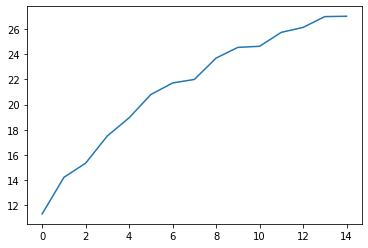

In [37]:
plt.plot(orig_test_acc)

In [60]:
orig_val_loss

array([2.2932558 , 0.5998181 , 0.55874026, 0.46569228, 0.45049158,
       0.4255676 , 0.3847248 , 0.40330774, 0.39204633, 0.37022448,
       0.3361154 , 0.3330903 , 0.32348287, 0.33008718, 0.30198124,
       0.31034064, 0.32422924, 0.28173184, 0.29986274, 0.31335452,
       0.2884902 , 0.3192304 , 0.26953194, 0.27360663, 0.28837383,
       0.28256062, 0.27020952, 0.27938017, 0.27500474, 0.28482935,
       0.2830521 , 0.25364268, 0.26431122, 0.26609266, 0.2623072 ,
       0.24247855, 0.31599626, 0.266008  , 0.25241718, 0.25159404,
       0.25465158, 0.2381976 , 0.26936   , 0.2949132 , 0.22524305,
       0.27760792, 0.27456635, 0.26015154, 0.2783044 , 0.28589192,
       0.25260788, 0.29126576, 0.2745214 , 0.31174105, 0.25607827,
       0.32937205, 0.25082582, 0.24957164, 0.27887645, 0.2519828 ,
       0.31203738, 0.3072598 , 0.28016475, 0.26036236, 0.25688252,
       0.2830533 , 0.2524959 , 0.2644796 , 0.28432667, 0.28638327,
       0.26213753, 0.26806572, 0.3232631 , 0.33061832, 0.29632

In [63]:
for param in model.rand_classifier.parameters():
    print(param)

Parameter containing:
tensor([[ 0.0221, -0.0360,  0.0109,  ..., -0.0212,  0.0420,  0.0539],
        [ 0.0665, -0.0150,  0.0654,  ..., -0.0893, -0.0182, -0.0902],
        [-0.0695, -0.0110, -0.0557,  ...,  0.0798, -0.0765,  0.0625],
        ...,
        [ 0.0803, -0.0046,  0.0478,  ...,  0.0588, -0.0892,  0.0326],
        [ 0.0360, -0.0322,  0.0301,  ..., -0.0137,  0.0948, -0.0082],
        [-0.0652,  0.0347, -0.0570,  ...,  0.0282,  0.0767,  0.0577]],
       requires_grad=True)
Parameter containing:
tensor([-0.0222,  0.0851,  0.0923, -0.0091,  0.0839, -0.0649, -0.0209,  0.0281,
        -0.0481,  0.0778,  0.0672, -0.0319, -0.0773, -0.0891, -0.0533,  0.0841,
        -0.0069, -0.0616,  0.0576,  0.0581,  0.0954,  0.0769,  0.0092,  0.0759,
        -0.0918,  0.0579,  0.0800,  0.0437,  0.0476, -0.0583, -0.0705, -0.0714,
         0.0169, -0.0576, -0.0534,  0.0145, -0.0887,  0.0359,  0.0824,  0.0519,
        -0.0280, -0.0057,  0.0309,  0.0348, -0.0592,  0.0321, -0.0852, -0.0133,
         0.0979